In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
import re
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.utils import shuffle
from sklearn.tree import export_graphviz
from collections import defaultdict

Wczytanie zbioru danych najlepszych zawodników NBA dla okresu 2009 - 2018, będzie potraktowany on jako próba ucząca ze względu na to, że zawiera w sobie informacje odnośnie tego jak zawodnicy byli oceniani. 

In [2]:
data = pd.read_csv("mvp_votings.csv")
data

,Unnamed: 0,fga,fg3a,fta,per,ts_pct,usg_pct,bpm,season,player,...,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,fg_pct,fg3_pct,ft_pct,ws,ws_per_48
0,0,20.1,5.1,10.2,31.1,0.604,33.5,11.8,2009-10,LeBron James,...,29.7,7.3,8.6,1.6,1.0,0.503,0.333,0.767,18.5,0.299
1,1,20.3,4.3,10.2,26.2,0.607,32.0,7.1,2009-10,Kevin Durant,...,30.1,7.6,2.8,1.4,1.0,0.476,0.365,0.900,16.1,0.238
2,2,21.5,4.1,7.4,21.9,0.545,32.3,4.1,2009-10,Kobe Bryant,...,27.0,5.4,5.0,1.5,0.3,0.456,0.329,0.811,9.4,0.160
3,3,10.2,0.1,10.0,24.0,0.630,23.9,4.4,2009-10,Dwight Howard,...,18.3,13.2,1.8,0.9,2.8,0.612,0.000,0.592,13.2,0.223
4,4,19.6,3.2,9.1,28.0,0.562,34.9,9.2,2009-10,Dwyane Wade,...,26.6,4.8,6.5,1.8,1.1,0.476,0.300,0.761,13.0,0.224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,117,18.0,1.2,5.3,25.0,0.570,29.1,3.9,2017-18,LaMarcus Aldridge,...,23.1,8.5,2.0,0.6,1.2,0.510,0.293,0.837,10.9,0.209
118,118,15.6,3.4,7.2,23.7,0.590,24.9,5.8,2017-18,Jimmy Butler,...,22.2,5.3,4.9,2.0,0.4,0.474,0.350,0.854,8.9,0.198
119,119,16.9,9.8,5.9,28.2,0.675,31.0,7.7,2017-18,Stephen Curry,...,26.4,5.1,6.1,1.6,0.2,0.495,0.423,0.921,9.1,0.267
120,120,16.8,3.4,7.4,22.9,0.573,33.4,3.3,2017-18,Joel Embiid,...,22.9,11.0,3.2,0.6,1.8,0.483,0.308,0.769,6.2,0.155


Wczytanie zbioru danych najlepszych zawodników NBA dla sezonu 2019-20. To dla tego zbioru wyznaczone zostanie, przewidywana pozycja każdego z zawodników w rankingu na MVP. 

In [4]:
data1 = pd.read_csv("test.csv")
data1

,Unnamed: 0,fga,fg3a,fta,per,ts_pct,usg_pct,bpm,season,player,...,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,fg_pct,fg3_pct,ft_pct,ws,ws_per_48
0,1.0,1139,271,570,31.60,0.608,37.4,11.09,2019-20,Giannis Antetokounmpo,...,29.64,13.7,5.8,1.0,1.0,0.547,0.360,0.630,10.4,0.282
1,2.0,1386,769,719,28.40,0.616,36.4,9.00,2019-20,James Harden,...,34.63,6.4,7.4,1.7,0.9,0.435,0.352,0.860,11.5,0.245
2,3.0,994,194,433,28.25,0.614,29.7,8.50,2019-20,Anthony Davis,...,26.67,9.4,3.1,1.5,2.4,0.510,0.330,0.840,10.3,0.262
3,4.0,1111,491,491,27.75,0.584,37.0,8.40,2019-20,Luka Doncic,...,28.70,9.3,8.7,1.1,0.2,0.460,0.310,0.750,8.1,0.215
4,5.0,1016,292,350,26.76,0.585,33.2,9.00,2019-20,Kawhi Leonard,...,26.90,7.3,5.0,1.8,0.6,0.469,0.366,0.889,7.6,0.222
5,6.0,1176,381,343,26.00,0.582,31.6,8.70,2019-20,Lebron James,...,25.70,7.9,10.6,1.2,0.5,0.498,0.349,0.697,9.5,0.218


Określamy parametry, które będą podstawą do analizy zawodników 

In [5]:
para = ['fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'mp_per_g', 'pts_per_g', 'trb_per_g', 'ast_per_g',
       'stl_per_g', 'blk_per_g', 'fg_pct', 'fg3_pct', 'ft_pct', 'ws',
       'ws_per_48', 'win_pct']

Określenie zbioru treningowego. Głównym kryterium klasyfikującym będzie wartość zmiennej award_share - w analizie koszykówki jest to parametr określający prawdopodobieństwo wygranej danego zawodnika na podstawie tego ile punktów otrzymał za osiągniecia w stosunku do tego ile otrzymałby za osiągnięcia gdyby w każdym z nich był nr 1. 

In [6]:
train_data_x = data[para].to_numpy() #odpowiada za statystyki "z gry" każdego zawodnika 
train_data_y = data[['award_share']].to_numpy() #kryterium award share 
train_data_y = train_data_y.reshape(train_data_y.shape[0]) #obrót macierzy

Dla ustalenia rankinu koszykarzy w wyścigu o tytuł MVP wykorzystano metode Lasów losowych. Zrealizowano ją dla dwóch wskaźników - wskaźnik Giniego oraz wskaźnik permutacji MDA(Mean Decrease in Accuracy). Funkcja regresji analizuję współzmienniczość wszystkich zmiennych i dopasowuje do nich pewną funkcje.   

In [7]:
regressor = RandomForestRegressor(n_estimators=1000) #Buduje las 1000 drzew :P 
regressor.fit(train_data_x, train_data_y)
#Wskaźnik giniego 
gini_indices = np.argsort(regressor.feature_importances_)[::-1] 
#Wskaźnik permutacji
indices = permutation_importance(regressor, train_data_x, train_data_y, n_repeats=10,random_state=0).importances_mean 
num_indices = np.argsort(indices)[::-1]

Sprawdzam, które parametry mają największy wpływ na wartość award_share

In [8]:
print(f"Wskaźnik permutacji")
for index in num_indices:
    print(f"{para[index]}: {round(indices[index],5)}")
print(f"\nWskaźnik giniego")    
for index in gini_indices:
    print(f"{para[index]}: {round(regressor.feature_importances_[index],5)}")

Wskaźnik permutacji
ws: 0.44474
bpm: 0.08674
win_pct: 0.06167
usg_pct: 0.05438
pts_per_g: 0.04036
per: 0.03417
ws_per_48: 0.02692
fga: 0.01735
ast_per_g: 0.01626
ft_pct: 0.01596
mp_per_g: 0.01581
fg3a: 0.01203
ts_pct: 0.0112
fta: 0.00949
fg3_pct: 0.00821
fg_pct: 0.00772
trb_per_g: 0.00762
stl_per_g: 0.00538
blk_per_g: 0.00456

Wskaźnik giniego
ws: 0.40693
bpm: 0.12871
per: 0.08706
usg_pct: 0.06131
ws_per_48: 0.05838
win_pct: 0.05257
pts_per_g: 0.03921
fga: 0.02182
mp_per_g: 0.01992
ast_per_g: 0.0166
fg3a: 0.01581
ts_pct: 0.01496
ft_pct: 0.01481
fta: 0.0133
fg_pct: 0.01222
fg3_pct: 0.01213
trb_per_g: 0.00898
blk_per_g: 0.00784
stl_per_g: 0.00744


Na podstawie powyższego widać, że największy wpływ na wartość award_share ma parametr ws(win_shares - mówi o tym ile dodatkowych zwycięstw zawodnik dał swojej drużynie). 
Na podstawie powyższej analizy możemy ograniczyć liczbę parametrów, które bierzemy pod uwagę, znaczenie dużej liczby parametrów jest marginalne.

Kolejną sensowną analiza wymiarowości problemu jest narysowanie macierzy korelacji pomiędzy zmiennymi. 

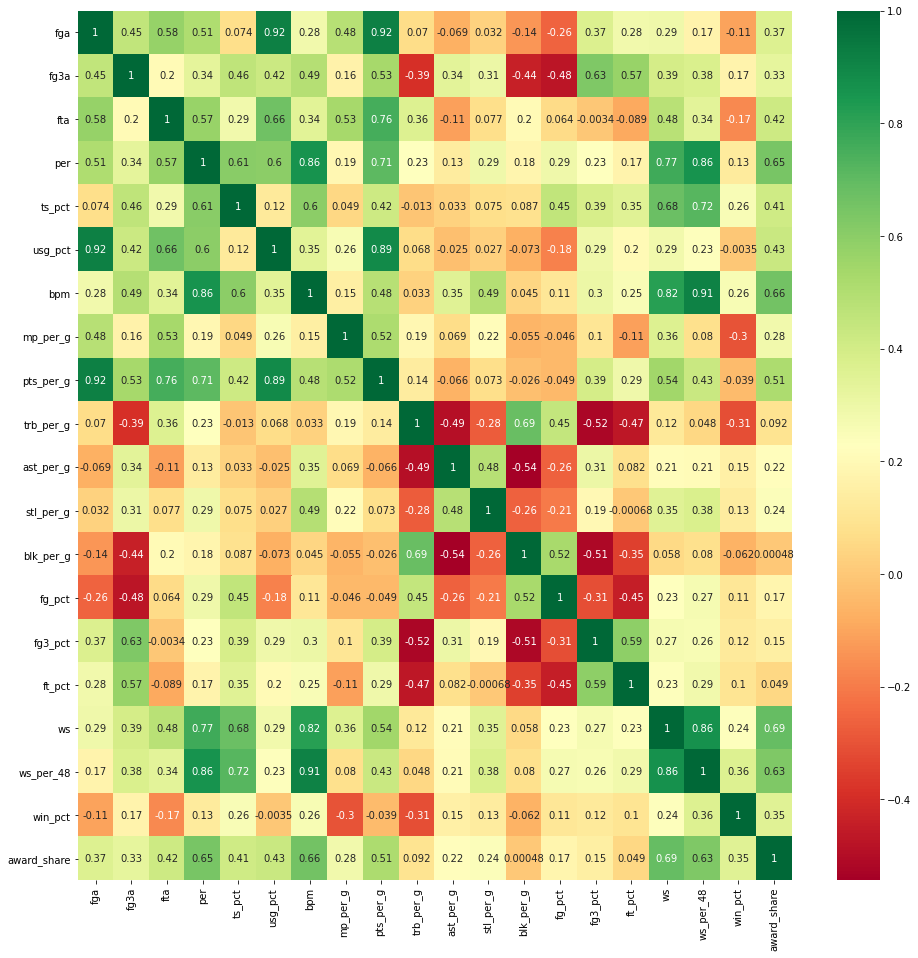

In [9]:
data = data[para + ["award_share"]]
fig = plt.figure(figsize=(16, 16))
fig.set_facecolor('white')
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn");


Na podstawie powyższego, w pewnym sensie też zgodnie z intuicją, fga (field goal attempts) na rzecz pozostawienia jedynie pts_per_game(points per game). Istnieje również dość silna zależność pomiedzy ws(win shares) a ws_per_48(win shares per 48 minutes). Podobnie z wieloma innymi parametrami.

Korzystając z wskaźników ważności oraz macierzy korelacji wybrano nowy zestaw danych, optymalizujący proces obliczeniowy. 

In [10]:
para_new = ['fga', 'fg3a', 'fta', 'per', 'ts_pct', 'usg_pct', 'bpm',
       'mp_per_g', 'pts_per_g','ast_per_g',
       'fg_pct', 'fg3_pct', 'ft_pct', 'ws', 'win_pct']

para_new_2 = ['per', 'usg_pct', 'bpm','mp_per_g', 'pts_per_g', 'ws', 'win_pct']

Skonstruowano funkcje, która pozwala wybrać liczbę drzew z jakich będzie składał się las oraz parametry dla których będzie przeprowadzana analiza. 

In [11]:
def predict_MVP(n_estimators=100,para=para):
    
    regressor = RandomForestRegressor(n_estimators,bootstrap=False) 
    train_x = data[para].to_numpy()
    train_y = data[['award_share']].to_numpy()

    train_x, train_y = shuffle(train_x, train_y)
    train_y = train_y.reshape(train_y.shape[0], )
    
    test_x = data1[para].to_numpy()
    test_x = np.nan_to_num(test_x)
    
    regressor.fit(train_x, train_y)
    predict_y = regressor.predict(test_x)
    sorted_indices = np.argsort(predict_y)[::-1]
    predictions = predict_y[sorted_indices]
    
    print(f"Predictions:")
    for i in range(6):
        print(f"{i+1}. {data1.iloc[sorted_indices[i]].player}: {round(predictions[i],3)}")
        
    

In [12]:
predict_MVP(1000,para_new_2)

Predictions:
1. Giannis Antetokounmpo: 0.31
2. Luka Doncic: 0.28
3. James Harden: 0.28
4. Lebron James: 0.043
5. Kawhi Leonard: 0.024
6. Anthony Davis: 0.023


In [13]:
predict_MVP(1000,para_new)

Predictions:
1. Kawhi Leonard: 0.625
2. Anthony Davis: 0.587
3. Lebron James: 0.411
4. Giannis Antetokounmpo: 0.394
5. Luka Doncic: 0.319
6. James Harden: 0.299


In [14]:
predict_MVP(1000,para)

Predictions:
1. Kawhi Leonard: 0.628
2. Anthony Davis: 0.623
3. Giannis Antetokounmpo: 0.381
4. Lebron James: 0.38
5. Luka Doncic: 0.309
6. James Harden: 0.302


Na podstawie powyższego możemy zaobserwować, że jednak mimo wszystko uwzględnienie wszystkich parametrów daje znacznie inny wynik "na szczycie" niż dla okrojonej listy parametrów.

In [15]:
predict_MVP(1000,para)

Predictions:
1. Kawhi Leonard: 0.626
2. Anthony Davis: 0.618
3. Lebron James: 0.381
4. Giannis Antetokounmpo: 0.38
5. Luka Doncic: 0.312
6. James Harden: 0.301


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
transformed = scaler.fit_transform(data)
pca = PCA(n_components=1)
decomposed = pca.fit_transform(transformed)

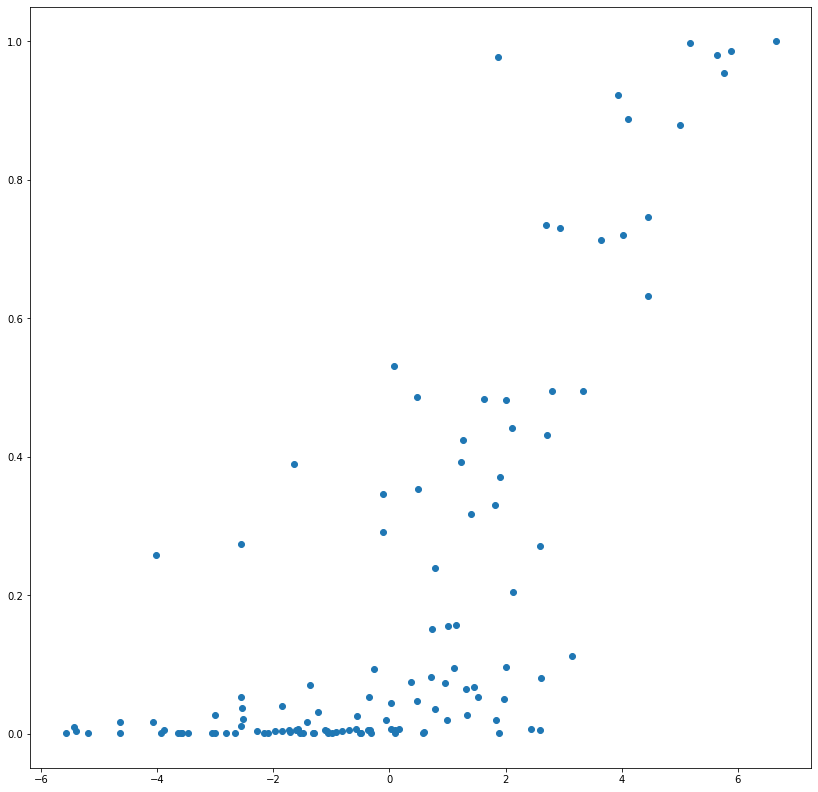

In [18]:
plt.figure(figsize=(14, 14))

plt.scatter(decomposed, data.award_share);